In [47]:
import numpy as np
import cupy as cp

import poppy
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from scoobpsf import scoobm, agpm
reload(scoobm)

import lina
xp = lina.math_module.xp
from lina.imshows import imshow1, imshow2, imshow3

# import misc_funs as misc

poppy_log.disabled = True

pupil_diam = 6.75*u.mm
wavelength_c = 632.8e-9*u.m

dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, rotation=20)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.6*u.mm/2, gray_pixel=False)




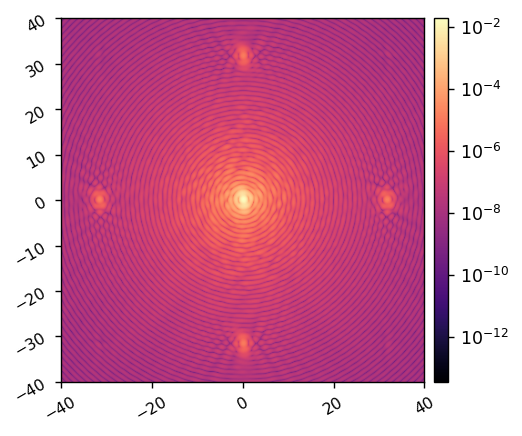

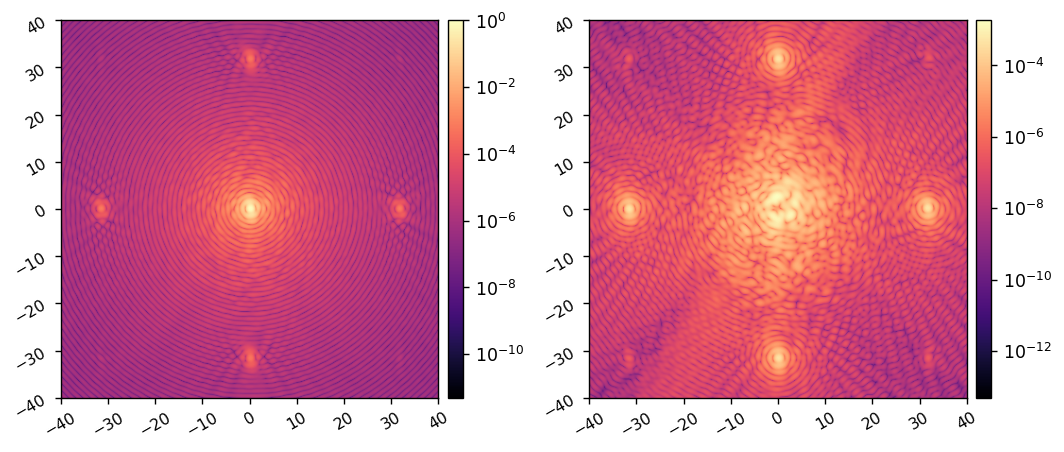

In [58]:
reload(scoobm)
model = scoobm.SCOOBM(dm_ref=dm_flat)
model.npix = 512
model.oversample = 4
model.det_rotation = 0

ref_im = model.snap(True)

model.imnorm = ref_im.max()
normalized_im = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

occ_im = model.snap()
imshow2(normalized_im, occ_im, lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

Nact = model.Nact
npsf = model.npsf
psf_pixelscale_lamD = model.psf_pixelscale_lamD

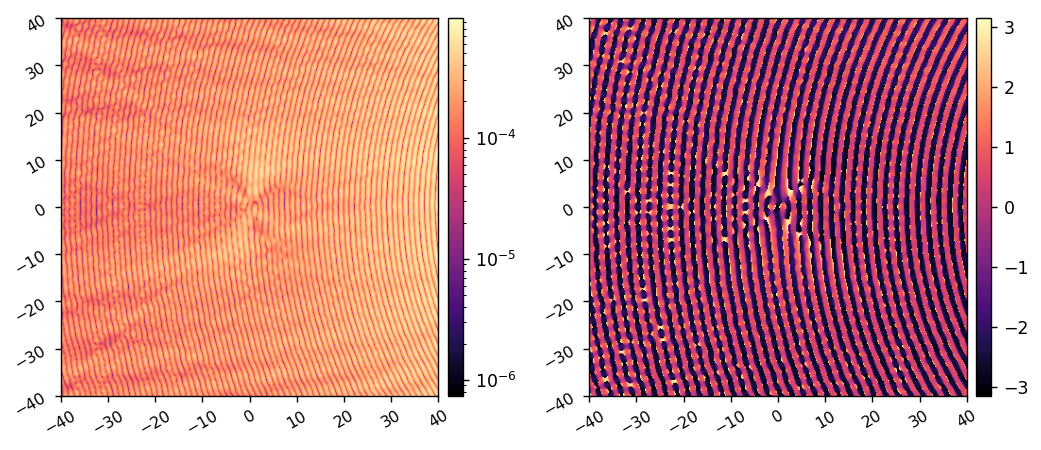

In [3]:
model.source_offset = (100,0)
im = model.calc_psf(True)

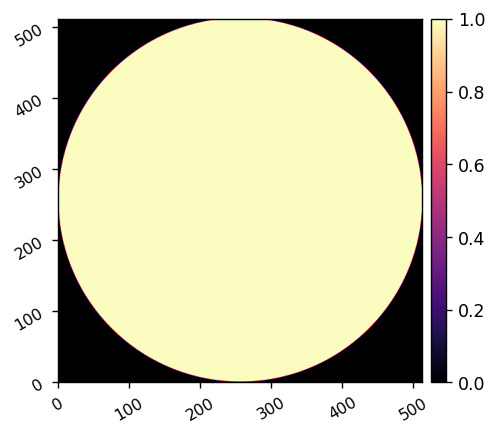

16


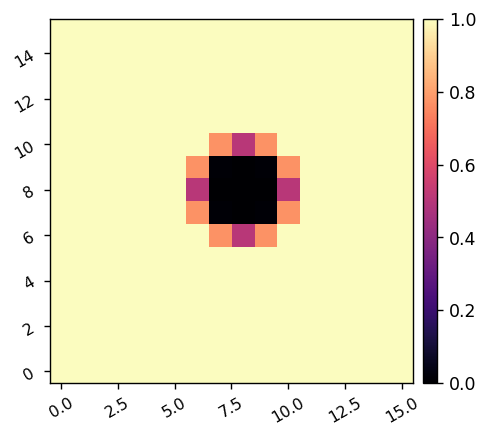

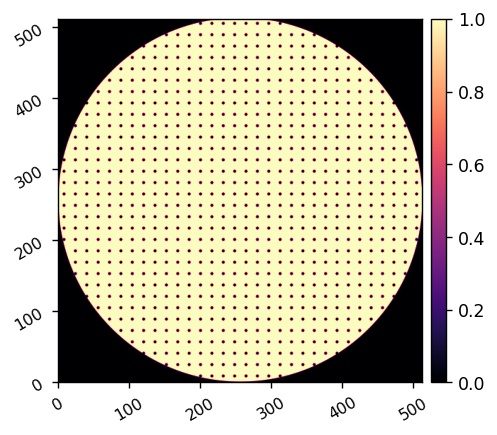

In [4]:
reload(lina.utils)
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
ap = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)
imshow1(ap)

grating_period = pupil_diam.to(u.m)/34
grating_period_pix = grating_period.to_value(u.m)/wf.pixelscale.to_value(u.m/u.pix)
grating_period_pix = round(grating_period_pix/2)*2
print(grating_period_pix)
# grating_period = 20 # in pixels

gwf = poppy.FresnelWavefront(beam_radius=grating_period, npix=grating_period_pix, oversample=1)
grating_obs = poppy.InverseTransmission(poppy.CircularAperture(radius=50*u.um)).get_transmission(gwf)
imshow1(grating_obs)

nobs = model.npix//grating_period_pix

grating = lina.utils.pad_or_crop(xp.tile(grating_obs, (nobs,nobs)), model.npix)*ap
imshow1(grating)

G = poppy.ArrayOpticalElement(transmission=grating, pixelscale=wf.pixelscale)

In [11]:
model.npsf

400

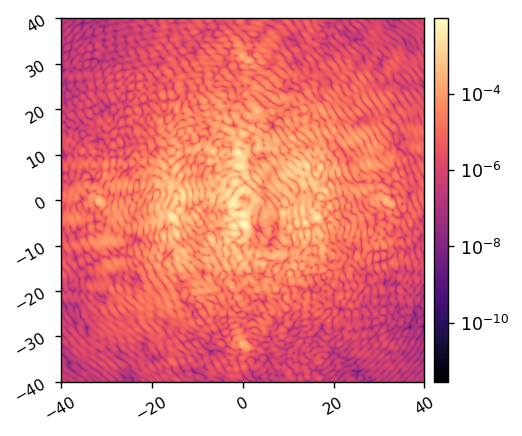

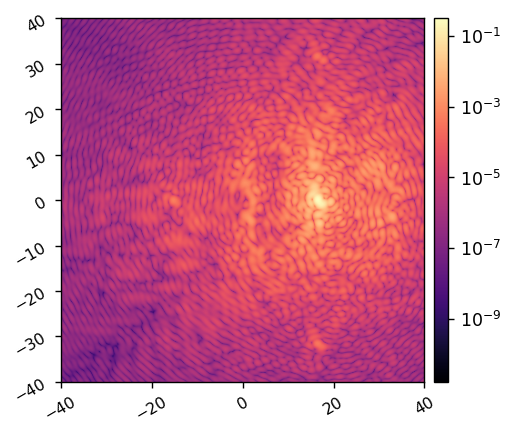

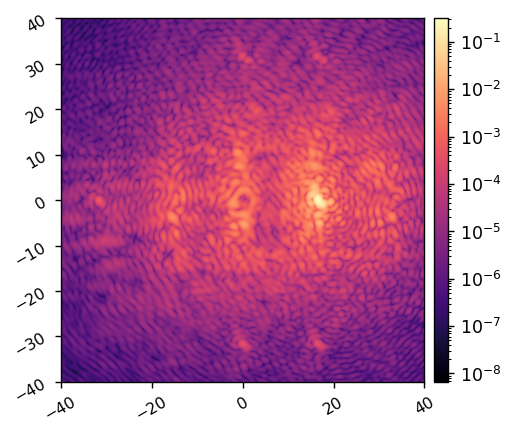

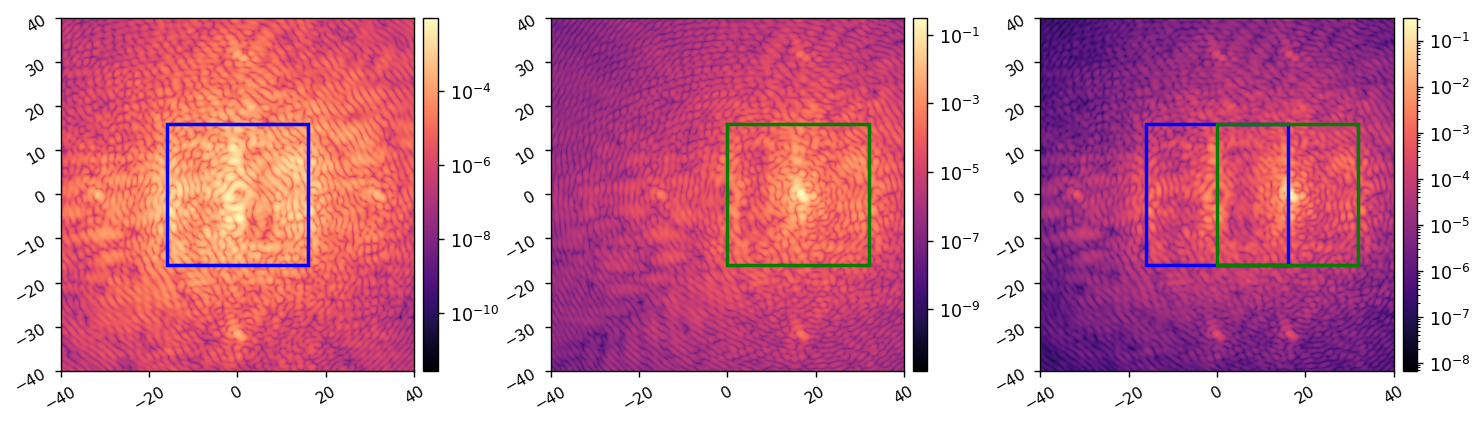

In [56]:
model.OPD = None
# model.OPD = G
model.npsf = 400
model.source_offset = (0,0)
im_on = model.snap(True)

offset = (16,0)
model.source_offset = offset
im_off = model.snap(True)

im = im_on + im_off
imshow1(im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

rect1 = Rectangle((-16,-16), 32, 32, fill=False, linewidth=2, color='b')
rect2 = Rectangle((-16+offset[0],-16+offset[1]), 32, 32, fill=False, linewidth=2, color='g')
rect3 = Rectangle((-16,-16), 32, 32, fill=False, linewidth=2, color='b')
rect4 = Rectangle((-16+offset[0],-16+offset[1]), 32, 32, fill=False, linewidth=2, color='g')
imshow3(im_on, im_off, im, lognorm=True, pxscl=model.psf_pixelscale_lamD, 
        patches1=[rect1], patches2=[rect2], patches3=[rect3, rect4])

In [11]:
15/model.psf_pixelscale_lamD

75.0

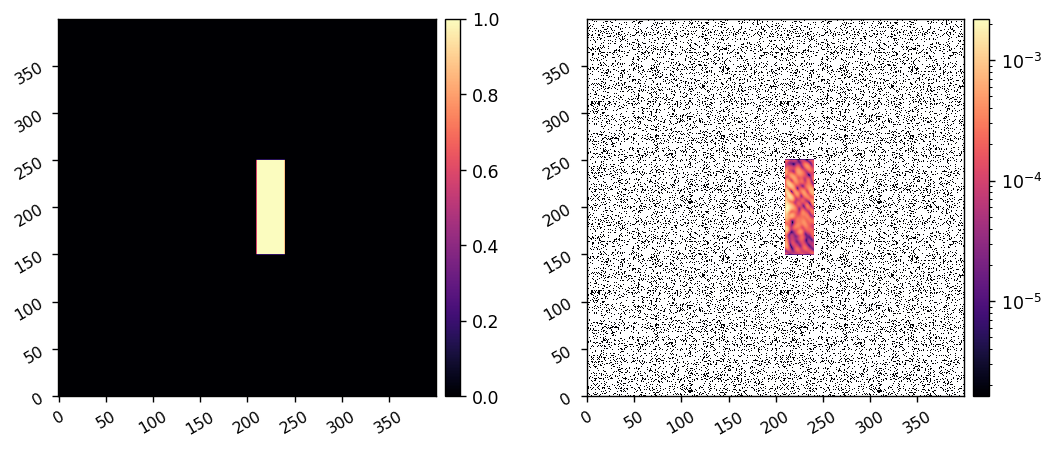

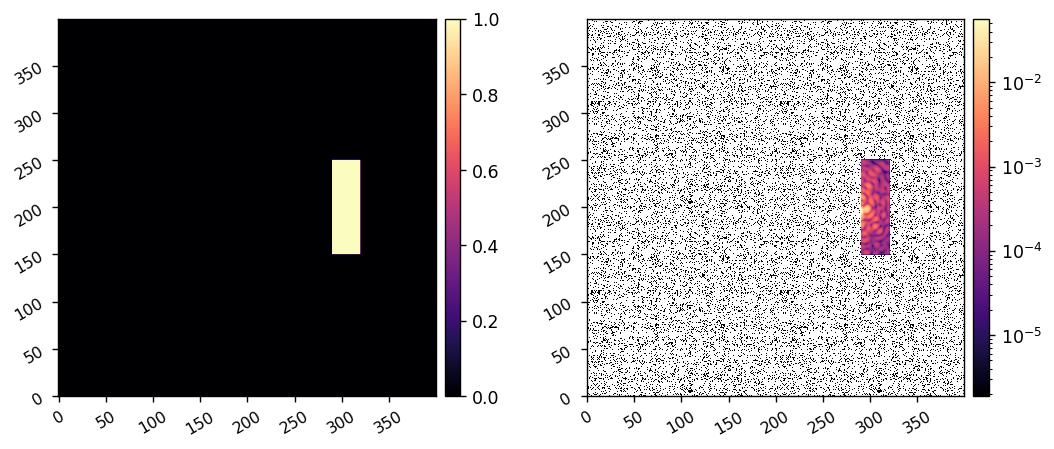

In [57]:
reload(lina.utils)
npsf = model.npsf
Nact = model.Nact

xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*model.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)

# Create the mask that is used to select which region to make dark.
dark_params = {
    'xi':2,
    'xo':8,
    'yi':-10,
    'yo':10,
}
dark_mask_on = lina.utils.create_box_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask_on, dark_mask_on*im, lognorm2=True)

dark_params = {
    'xi':2,
    'xo':8,
    'yi':-10,
    'yo':10,
    'x_shift':offset[0]/model.psf_pixelscale_lamD,
    'y_shift':offset[1]/model.psf_pixelscale_lamD,
}
dark_mask_off = lina.utils.create_box_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask_off, dark_mask_off*im, lognorm2=True)




In [46]:
dark_mask_on.sum(), dark_mask_off.sum()

(array(3000), array(3000))

In [22]:
reload(lina)

<module 'lina' from 'c:\\users\\kian\\projects\\lina\\lina\\__init__.py'>

In [40]:
reload(lina.bsefc)

model.set_dm(dm_flat)
epsilon = 1e-9 # poke amplitudes (DM surface)
jac = lina.bsefc.build_jacobian(model, epsilon, 
                                dark_mask_on, dark_mask_on, 
                                bs_offset=(15,0),
                                plot=False)

	Calculated response for mode 1/952. Elapsed time=0.555 sec.
	Calculated response for mode 2/952. Elapsed time=1.100 sec.
	Calculated response for mode 3/952. Elapsed time=1.645 sec.
	Calculated response for mode 4/952. Elapsed time=2.187 sec.
	Calculated response for mode 5/952. Elapsed time=2.730 sec.
	Calculated response for mode 6/952. Elapsed time=3.272 sec.
	Calculated response for mode 7/952. Elapsed time=3.815 sec.
	Calculated response for mode 8/952. Elapsed time=4.353 sec.
	Calculated response for mode 9/952. Elapsed time=4.895 sec.
	Calculated response for mode 10/952. Elapsed time=5.433 sec.
	Calculated response for mode 11/952. Elapsed time=5.970 sec.
	Calculated response for mode 12/952. Elapsed time=6.509 sec.
	Calculated response for mode 13/952. Elapsed time=7.047 sec.
	Calculated response for mode 14/952. Elapsed time=7.586 sec.
	Calculated response for mode 15/952. Elapsed time=8.126 sec.
	Calculated response for mode 16/952. Elapsed time=8.663 sec.
	Calculated respo

	Calculated response for mode 131/952. Elapsed time=71.149 sec.
	Calculated response for mode 132/952. Elapsed time=71.690 sec.
	Calculated response for mode 133/952. Elapsed time=72.229 sec.
	Calculated response for mode 134/952. Elapsed time=72.770 sec.
	Calculated response for mode 135/952. Elapsed time=73.311 sec.
	Calculated response for mode 136/952. Elapsed time=73.852 sec.
	Calculated response for mode 137/952. Elapsed time=74.393 sec.
	Calculated response for mode 138/952. Elapsed time=74.936 sec.
	Calculated response for mode 139/952. Elapsed time=75.477 sec.
	Calculated response for mode 140/952. Elapsed time=76.018 sec.
	Calculated response for mode 141/952. Elapsed time=76.558 sec.
	Calculated response for mode 142/952. Elapsed time=77.103 sec.
	Calculated response for mode 143/952. Elapsed time=77.644 sec.
	Calculated response for mode 144/952. Elapsed time=78.189 sec.
	Calculated response for mode 145/952. Elapsed time=78.736 sec.
	Calculated response for mode 146/952. E

	Calculated response for mode 258/952. Elapsed time=140.220 sec.
	Calculated response for mode 259/952. Elapsed time=140.761 sec.
	Calculated response for mode 260/952. Elapsed time=141.303 sec.
	Calculated response for mode 261/952. Elapsed time=141.843 sec.
	Calculated response for mode 262/952. Elapsed time=142.384 sec.
	Calculated response for mode 263/952. Elapsed time=142.926 sec.
	Calculated response for mode 264/952. Elapsed time=143.468 sec.
	Calculated response for mode 265/952. Elapsed time=144.009 sec.
	Calculated response for mode 266/952. Elapsed time=144.550 sec.
	Calculated response for mode 267/952. Elapsed time=145.091 sec.
	Calculated response for mode 268/952. Elapsed time=145.632 sec.
	Calculated response for mode 269/952. Elapsed time=146.173 sec.
	Calculated response for mode 270/952. Elapsed time=146.715 sec.
	Calculated response for mode 271/952. Elapsed time=147.255 sec.
	Calculated response for mode 272/952. Elapsed time=147.796 sec.
	Calculated response for 

	Calculated response for mode 385/952. Elapsed time=209.258 sec.
	Calculated response for mode 386/952. Elapsed time=209.794 sec.
	Calculated response for mode 387/952. Elapsed time=210.330 sec.
	Calculated response for mode 388/952. Elapsed time=210.867 sec.
	Calculated response for mode 389/952. Elapsed time=211.407 sec.
	Calculated response for mode 390/952. Elapsed time=211.943 sec.
	Calculated response for mode 391/952. Elapsed time=212.480 sec.
	Calculated response for mode 392/952. Elapsed time=213.016 sec.
	Calculated response for mode 393/952. Elapsed time=213.553 sec.
	Calculated response for mode 394/952. Elapsed time=214.090 sec.
	Calculated response for mode 395/952. Elapsed time=214.626 sec.
	Calculated response for mode 396/952. Elapsed time=215.163 sec.
	Calculated response for mode 397/952. Elapsed time=215.700 sec.
	Calculated response for mode 398/952. Elapsed time=216.236 sec.
	Calculated response for mode 399/952. Elapsed time=216.772 sec.
	Calculated response for 

	Calculated response for mode 512/952. Elapsed time=277.966 sec.
	Calculated response for mode 513/952. Elapsed time=278.573 sec.
	Calculated response for mode 514/952. Elapsed time=279.113 sec.
	Calculated response for mode 515/952. Elapsed time=279.654 sec.
	Calculated response for mode 516/952. Elapsed time=280.195 sec.
	Calculated response for mode 517/952. Elapsed time=280.739 sec.
	Calculated response for mode 518/952. Elapsed time=281.276 sec.
	Calculated response for mode 519/952. Elapsed time=281.813 sec.
	Calculated response for mode 520/952. Elapsed time=282.351 sec.
	Calculated response for mode 521/952. Elapsed time=282.888 sec.
	Calculated response for mode 522/952. Elapsed time=283.459 sec.
	Calculated response for mode 523/952. Elapsed time=283.996 sec.
	Calculated response for mode 524/952. Elapsed time=284.644 sec.
	Calculated response for mode 525/952. Elapsed time=285.181 sec.
	Calculated response for mode 526/952. Elapsed time=285.718 sec.
	Calculated response for 

	Calculated response for mode 639/952. Elapsed time=347.336 sec.
	Calculated response for mode 640/952. Elapsed time=347.885 sec.
	Calculated response for mode 641/952. Elapsed time=348.425 sec.
	Calculated response for mode 642/952. Elapsed time=348.967 sec.
	Calculated response for mode 643/952. Elapsed time=349.507 sec.
	Calculated response for mode 644/952. Elapsed time=350.048 sec.
	Calculated response for mode 645/952. Elapsed time=350.596 sec.
	Calculated response for mode 646/952. Elapsed time=351.137 sec.
	Calculated response for mode 647/952. Elapsed time=351.678 sec.
	Calculated response for mode 648/952. Elapsed time=352.219 sec.
	Calculated response for mode 649/952. Elapsed time=352.760 sec.
	Calculated response for mode 650/952. Elapsed time=353.301 sec.
	Calculated response for mode 651/952. Elapsed time=353.841 sec.
	Calculated response for mode 652/952. Elapsed time=354.381 sec.
	Calculated response for mode 653/952. Elapsed time=354.920 sec.
	Calculated response for 

	Calculated response for mode 766/952. Elapsed time=417.267 sec.
	Calculated response for mode 767/952. Elapsed time=417.812 sec.
	Calculated response for mode 768/952. Elapsed time=418.355 sec.
	Calculated response for mode 769/952. Elapsed time=418.899 sec.
	Calculated response for mode 770/952. Elapsed time=419.443 sec.
	Calculated response for mode 771/952. Elapsed time=419.987 sec.
	Calculated response for mode 772/952. Elapsed time=420.533 sec.
	Calculated response for mode 773/952. Elapsed time=421.080 sec.
	Calculated response for mode 774/952. Elapsed time=421.625 sec.
	Calculated response for mode 775/952. Elapsed time=422.169 sec.
	Calculated response for mode 776/952. Elapsed time=422.712 sec.
	Calculated response for mode 777/952. Elapsed time=423.257 sec.
	Calculated response for mode 778/952. Elapsed time=423.801 sec.
	Calculated response for mode 779/952. Elapsed time=424.344 sec.
	Calculated response for mode 780/952. Elapsed time=424.889 sec.
	Calculated response for 

	Calculated response for mode 893/952. Elapsed time=486.850 sec.
	Calculated response for mode 894/952. Elapsed time=487.394 sec.
	Calculated response for mode 895/952. Elapsed time=487.937 sec.
	Calculated response for mode 896/952. Elapsed time=488.482 sec.
	Calculated response for mode 897/952. Elapsed time=489.026 sec.
	Calculated response for mode 898/952. Elapsed time=489.569 sec.
	Calculated response for mode 899/952. Elapsed time=490.113 sec.
	Calculated response for mode 900/952. Elapsed time=490.657 sec.
	Calculated response for mode 901/952. Elapsed time=491.202 sec.
	Calculated response for mode 902/952. Elapsed time=491.746 sec.
	Calculated response for mode 903/952. Elapsed time=492.290 sec.
	Calculated response for mode 904/952. Elapsed time=492.834 sec.
	Calculated response for mode 905/952. Elapsed time=493.378 sec.
	Calculated response for mode 906/952. Elapsed time=493.922 sec.
	Calculated response for mode 907/952. Elapsed time=494.466 sec.
	Calculated response for 

In [44]:
import misc_funs as misc
misc.save_fits('bsjac.fits', lina.utils.ensure_np_array(jac))

Saved data to:  bsjac.fits


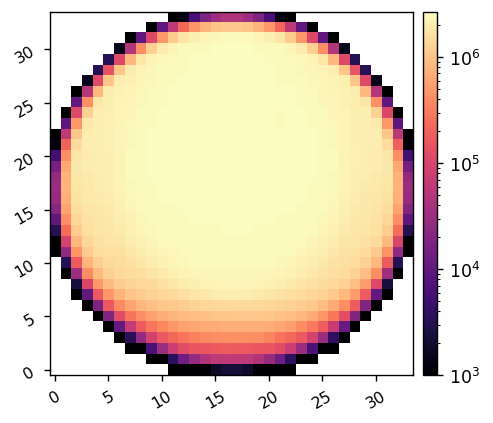

In [41]:
reload(lina.utils)
response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)
imshow1(response, lognorm=True, vmin=1e3)

In [45]:
jac.shape

(12000, 952)

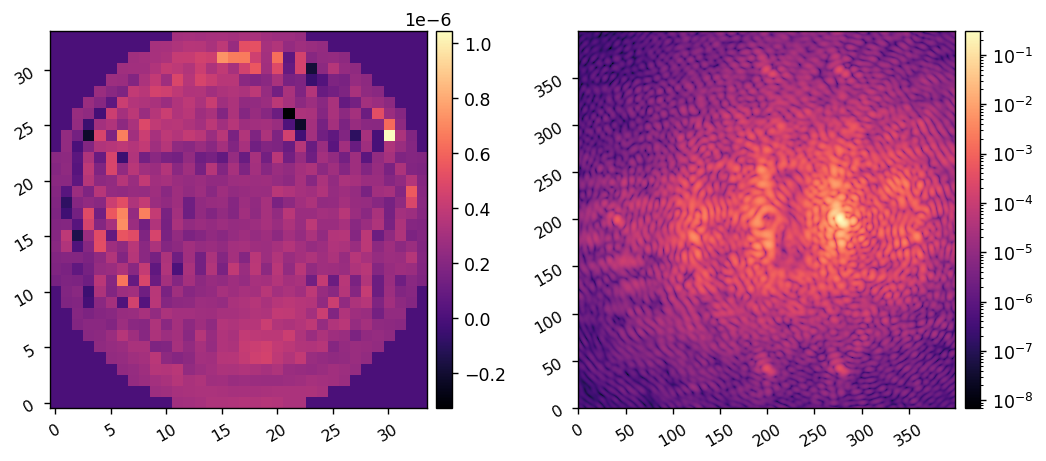

/home/u21/kianmilani/.conda/envs/poppy39-exp-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u21/kianmilani/.conda/envs/poppy39-exp-env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


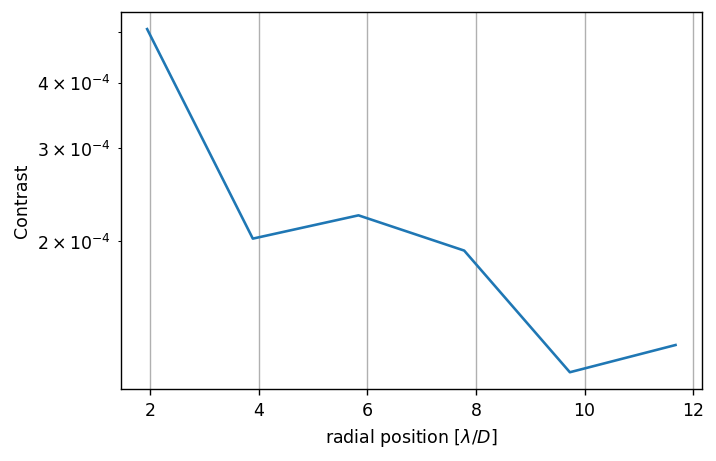

EFC completed in 23.398 sec.


In [43]:
reload(lina.bsefc)
reload(lina.utils)
model.set_dm(dm_flat)

bs_offset = (15,0)
reg_conds = [(-1, 10), (-2,10), (-2,20)]

for i in range(len(reg_conds)):
    control_matrix = lina.utils.beta_reg(jac, reg_conds[i][0])
    
    ims, commands = lina.bsefc.run_efc_perfect(model, bs_offset,
                                            jac, 
                                            control_matrix,
                                            dark_mask_on, 
                                               dark_mask_on,
                                            Imax_unocc=1,
                                            efc_loop_gain=0.5, 
                                            iterations=reg_conds[i][1], 
#                                             plot_all=True, 
                                            plot_sms=True,
                                             plot_radial_contrast=True)